# Charging Station/Plug Classifier

This notebook contains code to train, test, and make predictions with a model that classifies images as either a charging plug or a charging station for electric vehicles.

## 1. Importing Dependencies

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import glob
from pathlib import Path
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# force TensorFlow to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Using CPU only for training")

Using CPU only for training


## 2. Define Parameters

In [2]:
# paths
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Image params
img_width, img_height = 224, 224
batch_size = 32

# Model params
model_path = "charging_classifier_model.h5"

## 3. Data Preparation

In [3]:
# training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#  generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 552 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


## 4. Model Building

In [4]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

# Build the model
model = build_model()
model.summary()

d:\Software\Anaconda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training
PLEASE DELETE PREV .keras FILE OTHERWISE A FILE NOT SAVED ERROR WILL BE SHOWN!!!!!!!!!!

In [5]:
def train_model(model, epochs=58):
    # callbacks
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Training model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[checkpoint, early_stopping]
    )
    
    # Safely define model save path
    save_path = Path.cwd() / model_path
    model.save(str(save_path))
    print("Training completed and model saved!")
    
    return history

# Run training
history = train_model(model)

d:\Software\Anaconda\envs\tensorflow_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5978 - loss: 0.7928
Epoch 1: val_accuracy improved from -inf to 0.90625, saving model to charging_classifier_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5980 - loss: 0.7938 - val_accuracy: 0.9062 - val_loss: 0.5062
Epoch 2/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 15s 957ms/step - accuracy: 0.8125 - loss: 0.5334

d:\Software\Anaconda\envs\tensorflow_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.90625
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.8125 - loss: 0.5334 - val_accuracy: 0.8698 - val_loss: 0.5013
Epoch 3/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7909 - loss: 0.5043
Epoch 3: val_accuracy did not improve from 0.90625
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7921 - loss: 0.5020 - val_accuracy: 0.8802 - val_loss: 0.3755
Epoch 4/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 15s 984ms/step - accuracy: 0.8750 - loss: 0.4119
Epoch 4: val_accuracy did not improve from 0.90625
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8750 - loss: 0.4119 - val_accuracy: 0.8490 - val_loss: 0.3992
Epoch 5/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8946 - loss: 0.3497
Epoch 5: val_accuracy improved from 0.90625 to 0.91667, saving model to charging_classifier_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8945 - loss: 0.3490 - val_accuracy: 0.9167 - val_loss: 0.2475
Epoch 6/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9062 - loss: 0.2330
Epoch 6: val_accuracy did not improve from 0.91667
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9062 - loss: 0.2330 - val_accuracy: 0.9167 - val_loss: 0.2465
Epoch 7/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9203 - loss: 0.2563
Epoch 7: val_accuracy did not improve from 0.91667
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9198 - loss: 0.2561 - val_accuracy: 0.9115 - val_loss: 0.2226
Epoch 8/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 15s 941ms/step - accuracy: 0.9688 - loss: 0.1901
Epoch 8: val_accuracy improved from 0.91667 to 0.92188, saving model to charging_classifier_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9688 - loss: 0.1901 - val_accuracy: 0.9219 - val_loss: 0.2055
Epoch 9/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9173 - loss: 0.2121
Epoch 9: val_accuracy did not improve from 0.92188
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9177 - loss: 0.2114 - val_accuracy: 0.9010 - val_loss: 0.2271
Epoch 10/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - accuracy: 0.8750 - loss: 0.1278
Epoch 10: val_accuracy did not improve from 0.92188
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.8750 - loss: 0.1278 - val_accuracy: 0.9062 - val_loss: 0.2063
Epoch 11/58
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9579 - loss: 0.1735
Epoch 11: val_accuracy did not improve from 0.92188
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9570 - loss: 0.1736 - val_accuracy: 0.9010 - val_loss: 0.2332
Epoch 12/58
 1/17 ━━━━━━━━━━━━━━━━━━━━ 14s 937ms/step - accuracy: 0.9688 - loss: 0.1377
Epoch 12: val_accuracy did not improve 

Training completed and model saved!


## 6. Plot Training Results

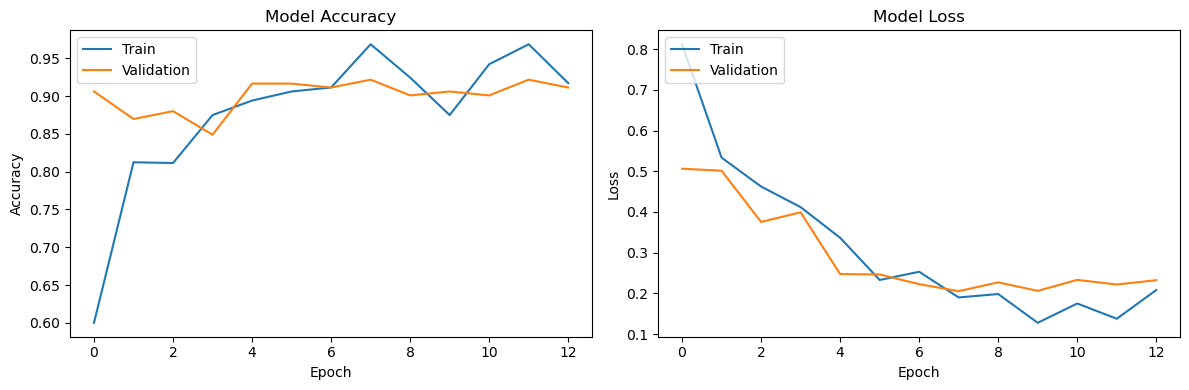

In [6]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

# Uncomment to plot after training
plot_training_history(history)

## 7. Model Evaluation

Found 98 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.8355 - loss: 0.3109

Test Accuracy: 0.8673
Test Loss: 0.2860
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step

Classification Report:
                  precision    recall  f1-score   support

   charging_plug       0.90      0.80      0.85        45
charging_station       0.84      0.92      0.88        53

        accuracy                           0.87        98
       macro avg       0.87      0.86      0.86        98
    weighted avg       0.87      0.87      0.87        98



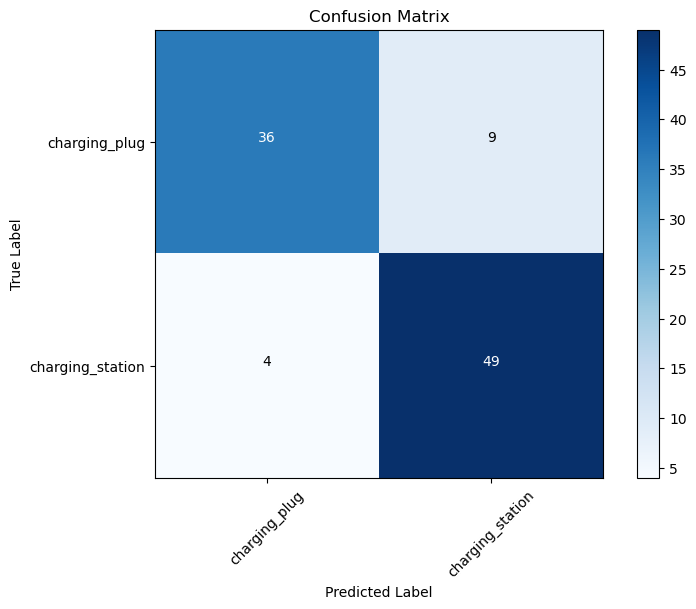

In [7]:
## 7. Model Evaluation

def load_trained_model():
    full_model_path = os.path.join(os.getcwd(), model_path)
    if not os.path.exists(full_model_path):
        print(f"Model file {full_model_path} not found. Please train the model first.")
        return None
    return load_model(full_model_path)

def evaluate_model():
    model = load_trained_model()
    if model is None:
        return

    has_subdirs = any(
        os.path.isdir(os.path.join(test_dir, item)) for item in os.listdir(test_dir)
    )

    if has_subdirs:
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )

        # Evaluate model
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"\nTest Accuracy: {test_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Get predictions
        predictions = model.predict(test_generator)
        predicted_classes = (predictions > 0.5).astype(int)
        true_classes = test_generator.classes

        # Get class names from directory
        class_names = list(test_generator.class_indices.keys())

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(true_classes, predicted_classes)

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Label the matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

    else:
        print("No subdirectories in test folder. Skipping confusion matrix and classification report.")
        
evaluate_model()

## 8. Test on Sample Images

Found 98 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


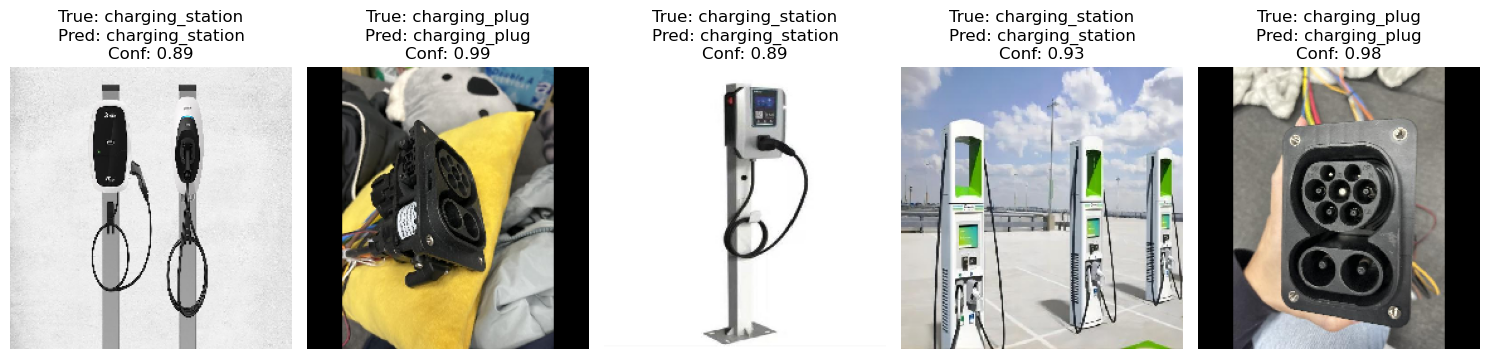

In [17]:
def test_multiple_images(num_samples=5):
    model = load_trained_model()
    if model is None:
        return
    
    # Create test generator without shuffling to maintain order
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    # Get class mapping
    class_indices = test_generator.class_indices
    classes = {v: k for k, v in class_indices.items()}
    
    # Get a batch of images and labels
    images, labels = next(test_generator)
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Display a subset of images
    fig, axes = plt.subplots(1, min(num_samples, len(images)), figsize=(15, 5))
    
    for i in range(min(num_samples, len(images))):
        ax = axes[i]
        ax.imshow(images[i])
        
        true_label = classes[int(labels[i])]
        pred_label = classes[predicted_classes[i][0]]
        confidence = predictions[i][0] if predicted_classes[i][0] == 1 else 1 - predictions[i][0]
        
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to test on sample images
test_multiple_images(5)

## 9. Predict Multiple Real Life Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


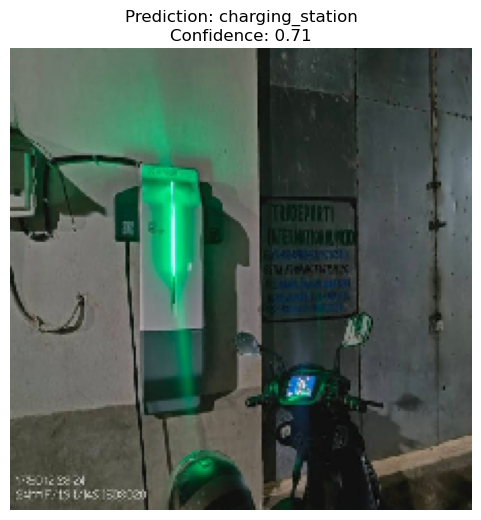

Image: IMG-20250408-WA0003.jpg
Prediction: charging_station
Confidence: 0.71

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


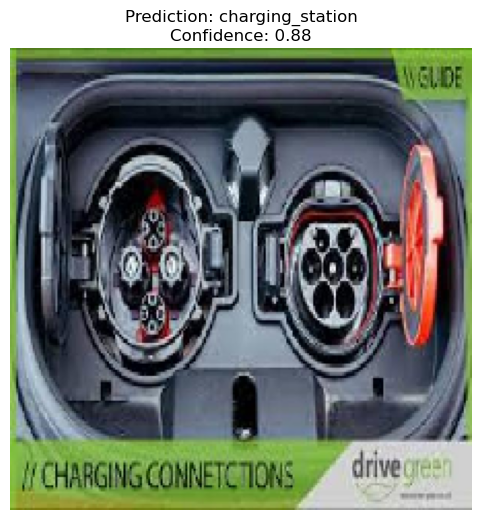

Image: images-6-_jpg.rf.41361da920191e32723a7503fa93e3db.jpg
Prediction: charging_station
Confidence: 0.88

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


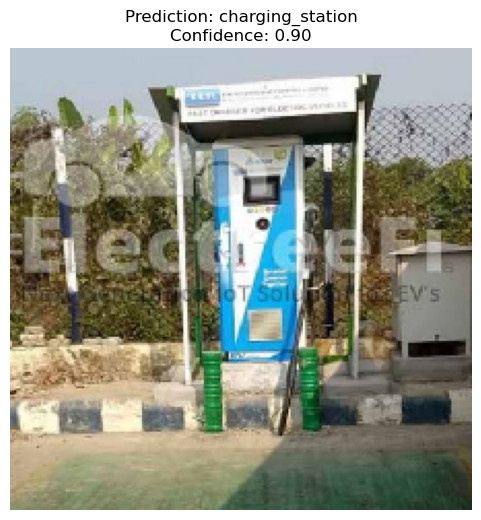

Image: IMG-20250408-WA0020.jpg
Prediction: charging_station
Confidence: 0.90

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


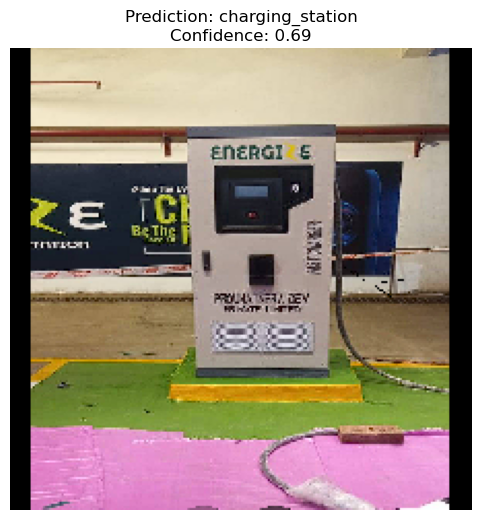

Image: Screenshot 2025-03-17 105538.png
Prediction: charging_station
Confidence: 0.69

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


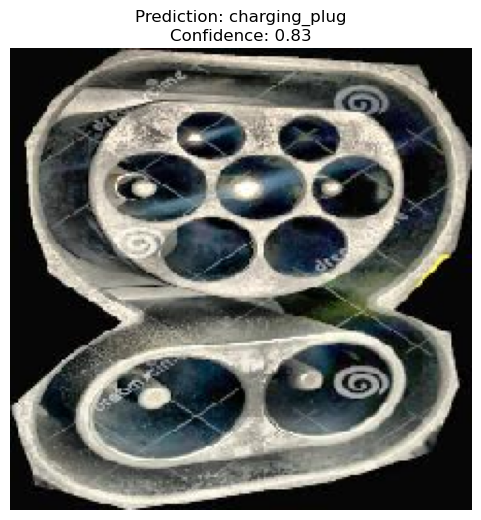

Image: charging-electric-vehicle-ev-process-ccs-port-plug-connected-to-charger-169907012_jpg.rf.58257e610730db165bfd0d629083db03.jpg
Prediction: charging_plug
Confidence: 0.83



In [14]:
def predict_sample_images(folder_path='image_checker', sample_size=5):
    model = load_trained_model()
    if model is None:
        return

    # Collect all image files from the folder
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    if not image_paths:
        print(f"No images found in {folder_path}")
        return

    # Select up to `sample_size` random images
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))

    for img_path in sample_paths:
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            # Make prediction
            prediction = model.predict(img_array)
            confidence = prediction[0][0]
            class_label = "charging_station" if confidence > 0.5 else "charging_plug"
            class_confidence = confidence if confidence > 0.5 else 1 - confidence

            # Display
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Prediction: {class_label}\nConfidence: {class_confidence:.2f}")
            plt.axis('off')
            plt.show()

            print(f"Image: {os.path.basename(img_path)}")
            print(f"Prediction: {class_label}")
            print(f"Confidence: {class_confidence:.2f}\n")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# 🔥 Call the function to test
predict_sample_images()


# 10. Predict Single Image Function

In [10]:
# 🔍 10. Predict Single Image Manually
def predict_single_image_manual(img_path):
    model = load_trained_model()
    if model is None:
        return
    
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Rescale

        # Make prediction
        prediction = model.predict(img_array)
        confidence = prediction[0][0]

        # Interpretation
        class_label = "charging_station" if confidence > 0.5 else "charging_plug"
        class_confidence = confidence if confidence > 0.5 else 1 - confidence

        # Display image with prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {class_label}\nConfidence: {class_confidence:.2f}")
        plt.axis('off')
        plt.show()

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Prediction: {class_label}")
        print(f"Confidence: {class_confidence:.2f}")

    except Exception as e:
        print(f"Error processing image: {e}")


# 11. Interactive File Picker/Single Image Prediction

In [11]:
import ipywidgets as widgets
from IPython.display import display
import os

# File picker UI
file_picker = widgets.Text(
    value='image_checker/',
    placeholder='Enter path to image (e.g. image_checker/sample.jpg)',
    description='Image Path:',
    layout=widgets.Layout(width='600px')
)

predict_button = widgets.Button(description='Predict Image ', button_style='success')

def on_button_clicked(b):
    img_path = file_picker.value.strip()
    if os.path.exists(img_path):
        predict_single_image_manual(img_path)
    else:
        print(f"❌ File not found: {img_path}")

predict_button.on_click(on_button_clicked)

display(file_picker, predict_button)


Text(value='image_checker/', description='Image Path:', layout=Layout(width='600px'), placeholder='Enter path …

Button(button_style='success', description='Predict Image ', style=ButtonStyle())

In [18]:
model = load_trained_model()
model_version = 2
model.save(f"./models/{model_version}.h5")